# Исследование по GMTS

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
# Загрузка 5 минутных данных
df = pd.read_csv('df_m5_TVI_CCI_T3_GHL.csv')
df['tradedate'] = pd.to_datetime(df['tradedate'])

df

,tradedate,open,high,low,close,tvi,cci,t3,ghl
0,2015-01-05 10:00:00,78450.0,78450.0,73200.0,73930.0,0,0,0,0
1,2015-01-05 10:05:00,73890.0,74700.0,73660.0,74700.0,1,0,1,0
2,2015-01-05 10:10:00,74700.0,74720.0,73830.0,73950.0,1,0,1,0
3,2015-01-05 10:15:00,73970.0,74440.0,73620.0,74430.0,1,0,1,0
4,2015-01-05 10:20:00,74400.0,74720.0,74220.0,74410.0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
410151,2024-12-17 23:25:00,72680.0,72720.0,72680.0,72690.0,1,1,1,1
410152,2024-12-17 23:30:00,72680.0,72690.0,72670.0,72690.0,1,1,1,1
410153,2024-12-17 23:35:00,72700.0,72790.0,72690.0,72790.0,1,1,1,1
410154,2024-12-17 23:40:00,72800.0,72820.0,72760.0,72810.0,1,1,1,1


Создание дата фрейма с колонкой **'buy_sell'** признаков открытия позиции Bay или Sell.

In [92]:
# Проверка, являются ли все значения в строке одинаковыми [1, 1, 1, 1] или [-1, -1, -1, -1]
df['IsAllSame'] = df[['tvi', 'cci', 't3', 'ghl']].eq(1).all(axis=1) | \
    df[['tvi', 'cci', 't3', 'ghl']].eq(-1).all(axis=1)

# Находим группы последовательных строк, где IsAllSame == True
df['Group'] = (df['IsAllSame'] != df['IsAllSame'].shift(1)).cumsum()

# Отмечаем только вторую строку в каждой группе, где IsAllSame == True
df['SecondInRow'] = df.groupby('Group').cumcount() == 1
df.loc[~df['IsAllSame'], 'SecondInRow'] = False  # Убираем строки, где IsAllSame == False

# Добавляем колонку 'sig', отмечаем только вторую строку в последовательности
df['sig'] = 0
df.loc[df['SecondInRow'], 'sig'] = 1

# Убираем вспомогательную колонку 'Group', 'IsAllSame', 'SecondInRow'
df.drop(columns=['Group', 'IsAllSame', 'SecondInRow'], inplace=True)

# Добавляем колонку с ценой открытия по сигналу
df['sig_open'] = df.apply(lambda x: x.open if x.sig == 1 else 0, axis=1)

# Добавляем колонку с направлением торговли
conditions = [
    (df['tvi'] == 1) & (df['cci'] == 1) & (df['t3'] == 1) & (df['ghl'] == 1) & (df['sig'] == 1),
    (df['tvi'] == -1) & (df['cci'] == -1) & (df['t3'] == -1) & (df['ghl'] == -1) & (df['sig'] == 1)
]
choices = [1, -1]
df['buy_sell'] = np.select(conditions, choices, default=0)

df

,tradedate,open,high,low,close,tvi,cci,t3,ghl,sig,sig_open,buy_sell
0,2015-01-05 10:00:00,78450.0,78450.0,73200.0,73930.0,0,0,0,0,0,0.0,0
1,2015-01-05 10:05:00,73890.0,74700.0,73660.0,74700.0,1,0,1,0,0,0.0,0
2,2015-01-05 10:10:00,74700.0,74720.0,73830.0,73950.0,1,0,1,0,0,0.0,0
3,2015-01-05 10:15:00,73970.0,74440.0,73620.0,74430.0,1,0,1,0,0,0.0,0
4,2015-01-05 10:20:00,74400.0,74720.0,74220.0,74410.0,1,0,1,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
410151,2024-12-17 23:25:00,72680.0,72720.0,72680.0,72690.0,1,1,1,1,0,0.0,0
410152,2024-12-17 23:30:00,72680.0,72690.0,72670.0,72690.0,1,1,1,1,0,0.0,0
410153,2024-12-17 23:35:00,72700.0,72790.0,72690.0,72790.0,1,1,1,1,0,0.0,0
410154,2024-12-17 23:40:00,72800.0,72820.0,72760.0,72810.0,1,1,1,1,0,0.0,0


Создаем колонку **"profit"** в которую записываем:  
если значение в колонке 'buy_sell' равно 1, то из ближайшего последующего значения в колонке 'sig_open' не равного 0, вычесть текущее значение в колонке 'sig_open'  
если значение в колонке 'buy_sell' равно -1, то из текущего значения в колонке 'sig_open', вычесть ближайшее последующее значение в колонке 'sig_open' не равное 0  
иначе, записать в колонку 0

In [93]:
def calculate_profit(row, sig_open_col, buy_sell_col):
    # Индекс текущей строки
    current_index = row.name

    # Значение buy_sell для текущей строки
    buy_sell = row[buy_sell_col]
    sig_open = row[sig_open_col]

    # Если buy_sell равно 1
    if buy_sell == 1:
        # Найти ближайшее последующее значение в sig_open, не равное 0
        for next_value in df.loc[current_index + 1:, sig_open_col]:
            if next_value != 0:
                return next_value - sig_open

    # Если buy_sell равно -1
    elif buy_sell == -1:
        # Найти ближайшее последующее значение в sig_open, не равное 0
        for next_value in df.loc[current_index + 1:, sig_open_col]:
            if next_value != 0:
                return sig_open - next_value

    # Если buy_sell не равно 1 или -1
    return 0

# Применить функцию ко всем строкам
df['profit'] = df.apply(calculate_profit, axis=1, sig_open_col='sig_open', buy_sell_col='buy_sell')

# Результат
df

,tradedate,open,high,low,close,tvi,cci,t3,ghl,sig,sig_open,buy_sell,profit
0,2015-01-05 10:00:00,78450.0,78450.0,73200.0,73930.0,0,0,0,0,0,0.0,0,0.0
1,2015-01-05 10:05:00,73890.0,74700.0,73660.0,74700.0,1,0,1,0,0,0.0,0,0.0
2,2015-01-05 10:10:00,74700.0,74720.0,73830.0,73950.0,1,0,1,0,0,0.0,0,0.0
3,2015-01-05 10:15:00,73970.0,74440.0,73620.0,74430.0,1,0,1,0,0,0.0,0,0.0
4,2015-01-05 10:20:00,74400.0,74720.0,74220.0,74410.0,1,0,1,0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
410151,2024-12-17 23:25:00,72680.0,72720.0,72680.0,72690.0,1,1,1,1,0,0.0,0,0.0
410152,2024-12-17 23:30:00,72680.0,72690.0,72670.0,72690.0,1,1,1,1,0,0.0,0,0.0
410153,2024-12-17 23:35:00,72700.0,72790.0,72690.0,72790.0,1,1,1,1,0,0.0,0,0.0
410154,2024-12-17 23:40:00,72800.0,72820.0,72760.0,72810.0,1,1,1,1,0,0.0,0,0.0


In [94]:
# Очистка df
df = df[df["profit"] != 0.0]

# Фильтрация строк с марта 2015 и времени до 19:00:00
df = df[
    (df["tradedate"] >= pd.Timestamp("2015-03-01")) & 
    (df["tradedate"].dt.time < pd.to_datetime("19:00:00").time())
]

df = df.copy().reset_index(drop=True)

# Добавление колонки с датой
df['date'] = df['tradedate'].dt.date

# Добавление колонки с временем
df['time'] = df['tradedate'].dt.time

# Учет спреда при симуляции торговли
df["profit"] = df["profit"] - 10

df

,tradedate,open,high,low,close,tvi,cci,t3,ghl,sig,sig_open,buy_sell,profit,date,time
0,2015-03-02 10:05:00,89890.0,90030.0,89550.0,89760.0,-1,-1,-1,-1,1,89890.0,-1,-180.0,2015-03-02,10:05:00
1,2015-03-02 11:05:00,90060.0,90220.0,89980.0,90060.0,1,1,1,1,1,90060.0,1,500.0,2015-03-02,11:05:00
2,2015-03-02 12:00:00,90570.0,90580.0,90270.0,90350.0,1,1,1,1,1,90570.0,1,-460.0,2015-03-02,12:00:00
3,2015-03-02 13:45:00,90120.0,90200.0,90070.0,90140.0,-1,-1,-1,-1,1,90120.0,-1,210.0,2015-03-02,13:45:00
4,2015-03-02 14:30:00,89900.0,89930.0,89530.0,89670.0,-1,-1,-1,-1,1,89900.0,-1,40.0,2015-03-02,14:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23414,2024-12-17 13:20:00,73760.0,73820.0,73730.0,73790.0,-1,-1,-1,-1,1,73760.0,-1,210.0,2024-12-17,13:20:00
23415,2024-12-17 14:20:00,73540.0,73540.0,73330.0,73340.0,-1,-1,-1,-1,1,73540.0,-1,280.0,2024-12-17,14:20:00
23416,2024-12-17 15:45:00,73250.0,73260.0,73150.0,73220.0,1,1,1,1,1,73250.0,1,-280.0,2024-12-17,15:45:00
23417,2024-12-17 16:15:00,72980.0,72990.0,72720.0,72770.0,-1,-1,-1,-1,1,72980.0,-1,360.0,2024-12-17,16:15:00


In [95]:
df_time = (
    df.groupby(['time'], as_index=False)
    .agg(
        total_profit=('profit', 'sum'),  # Сумма значений profit
        count_profit=('profit', 'count')  # Количество значений profit
    )
    .sort_values(['total_profit'], ascending=False)
)

df_time['profit_avg'] = df_time['total_profit'] / df_time['count_profit']

df_time['profit_avg'] = df_time['profit_avg'].round(2)

print(df_time.sort_values (by='profit_avg', ascending=False).head(20))

         time  total_profit  count_profit  profit_avg
0    07:00:00       49120.0            52      944.62
36   10:00:00      138740.0           279      497.28
41   10:25:00       27940.0           137      203.94
126  17:30:00       38280.0           210      182.29
24   09:00:00       13960.0            85      164.24
21   08:45:00        2830.0            20      141.50
62   12:10:00       30670.0           221      138.78
38   10:10:00       34600.0           256      135.16
64   12:20:00       26540.0           198      134.04
15   08:15:00        1320.0            10      132.00
123  17:15:00       25450.0           214      118.93
54   11:30:00       20430.0           181      112.87
132  18:00:00       21890.0           197      111.12
131  17:55:00       23770.0           219      108.54
111  16:15:00       22680.0           227       99.91
121  17:05:00       22180.0           235       94.38
6    07:30:00         470.0             5       94.00
74   13:10:00       22130.0 

In [96]:
# # Сохранение в файл
# df_time.sort_values(by='time', ascending=True).to_excel('GMTS_исследования_времени_торговли.xlsx')

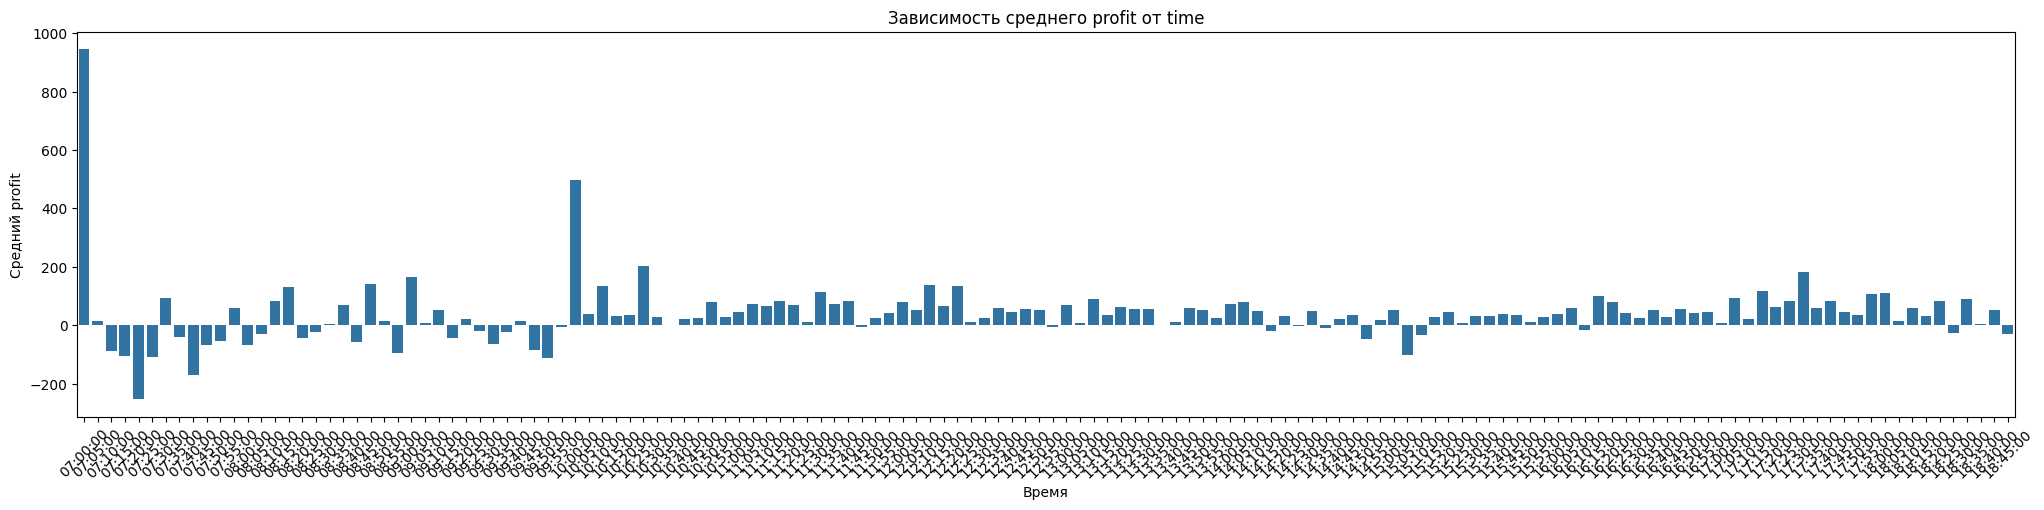

In [97]:
df_time = df_time.sort_values(by='time', ascending=True)

# Строим график зависимости
plt.figure(figsize=(25, 5))
sns.barplot(x=df_time['time'].astype(str), y=df_time['profit_avg'])
plt.xticks(rotation=45)  # Поворачиваем подписи оси X для читаемости
plt.title('Зависимость среднего profit от time')
plt.xlabel('Время')
plt.ylabel('Средний profit')
plt.show()

# Прибыль по дням после 15:15

In [98]:
# Фильтрация строк с 15:15:00
df_amer = df[
         (df["tradedate"].dt.time >= pd.to_datetime("15:15:00").time()) & 
         (df["tradedate"].dt.time < pd.to_datetime("18:20:00").time())
]

df_amer

,tradedate,open,high,low,close,tvi,cci,t3,ghl,sig,sig_open,buy_sell,profit,date,time
5,2015-03-02 16:25:00,89850.0,90030.0,89840.0,89900.0,1,1,1,1,1,89850.0,1,200.0,2015-03-02,16:25:00
6,2015-03-02 17:45:00,90060.0,90190.0,89960.0,90010.0,1,1,1,1,1,90060.0,1,-210.0,2015-03-02,17:45:00
13,2015-03-03 15:20:00,92110.0,92280.0,92060.0,92190.0,1,1,1,1,1,92110.0,1,-370.0,2015-03-03,15:20:00
14,2015-03-03 15:40:00,91750.0,91760.0,91630.0,91670.0,-1,-1,-1,-1,1,91750.0,-1,250.0,2015-03-03,15:40:00
15,2015-03-03 17:20:00,91490.0,91690.0,91440.0,91680.0,1,1,1,1,1,91490.0,1,-340.0,2015-03-03,17:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23409,2024-12-16 16:05:00,73740.0,73880.0,73730.0,73860.0,1,1,1,1,1,73740.0,1,0.0,2024-12-16,16:05:00
23410,2024-12-16 17:15:00,73750.0,73800.0,73690.0,73780.0,-1,-1,-1,-1,1,73750.0,-1,440.0,2024-12-16,17:15:00
23416,2024-12-17 15:45:00,73250.0,73260.0,73150.0,73220.0,1,1,1,1,1,73250.0,1,-280.0,2024-12-17,15:45:00
23417,2024-12-17 16:15:00,72980.0,72990.0,72720.0,72770.0,-1,-1,-1,-1,1,72980.0,-1,360.0,2024-12-17,16:15:00


In [99]:
df_amer_date = (
    df.groupby(['date'], as_index=False)
    .agg(
        total_profit=('profit', 'sum'),  # Сумма значений profit
        count_profit=('profit', 'count')  # Количество значений profit
    )
    # .sort_values(['total_profit'], ascending=False)
)

# df_amer_date.sort_values(by='date', ascending=True).to_excel('GMTS_даты_торговли.xlsx')

df_amer_date

,date,total_profit,count_profit
0,2015-03-02,170.0,8
1,2015-03-03,2220.0,10
2,2015-03-04,1870.0,9
3,2015-03-05,1150.0,11
4,2015-03-06,2570.0,9
...,...,...,...
2456,2024-12-11,420.0,8
2457,2024-12-12,50.0,13
2458,2024-12-13,680.0,12
2459,2024-12-16,1780.0,8


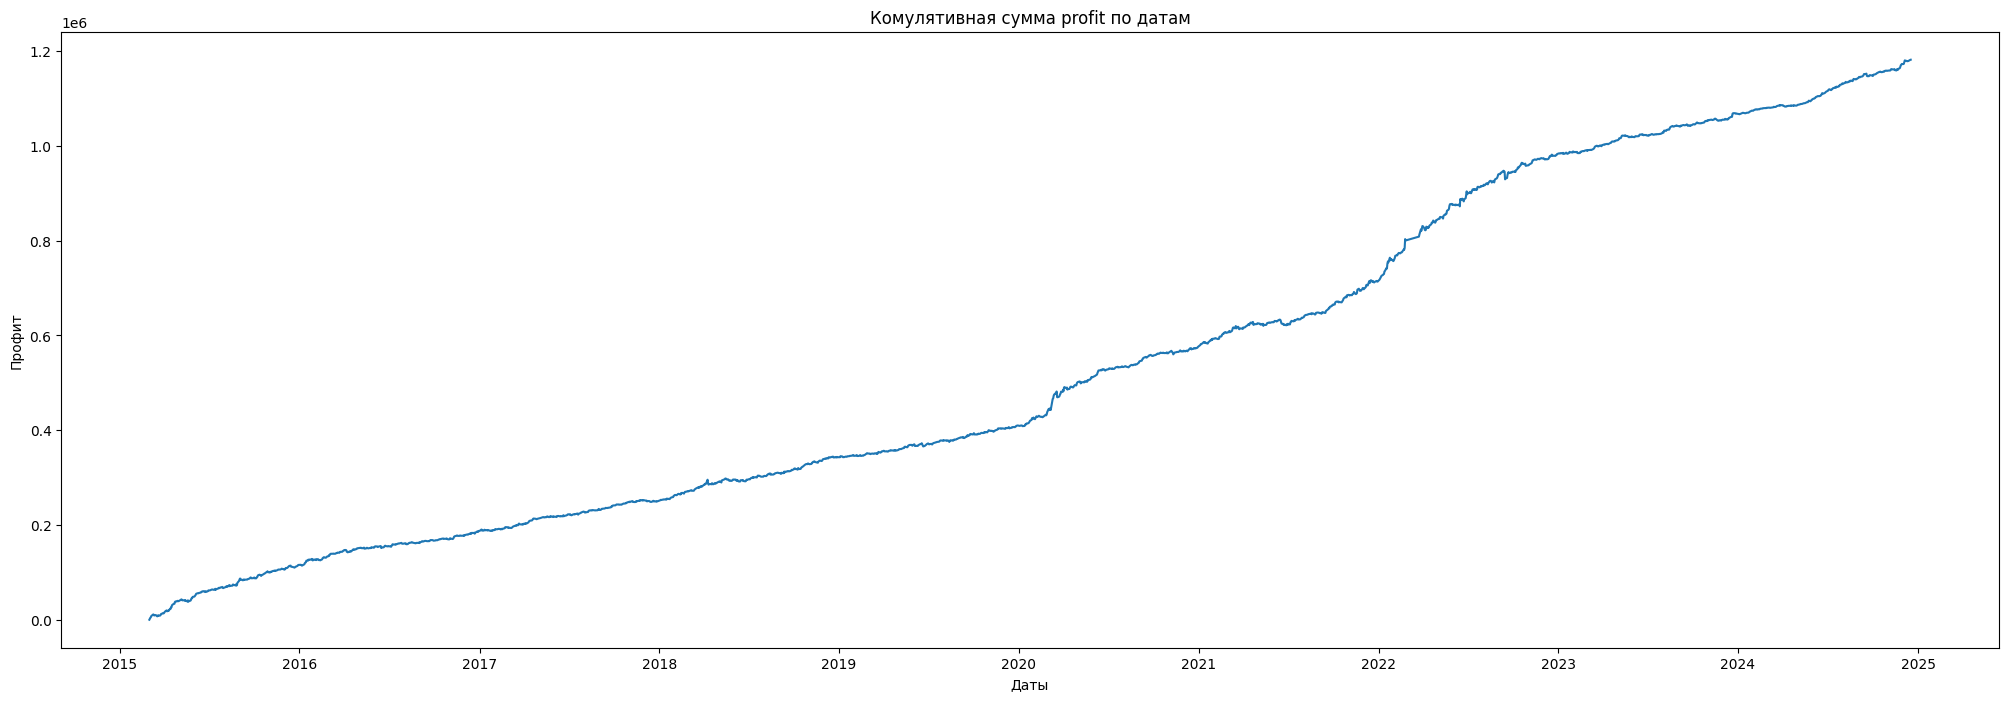

In [100]:
df_amer_date['sum_profit'] = df_amer_date['total_profit'].cumsum()

plt.figure(figsize=(25, 8))
sns.lineplot(data=df_amer_date, x=df_amer_date['date'], y='sum_profit')
plt.title('Комулятивная сумма profit по датам')
plt.xlabel('Даты')
plt.ylabel('Профит')
plt.show()

